[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MatteoFalcioni/Learning-LangGraph/blob/main/notebooks/8_agent_collaboration.ipynb)

### Setup

#### Install requirements

In [1]:
%pip install -q -U -r https://raw.githubusercontent.com/MatteoFalcioni/Learning-LangGraph/main/requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### local (notebooks or files)

In [2]:
from dotenv import load_dotenv
load_dotenv()  # load api keys

True

#### Colab

In [3]:
from google.colab import userdata
import os

REQUIRED_KEYS = [
    'OPENAI_API_KEY',
    'LANGSMITH_TRACING',
    'LANGSMITH_ENDPOINT',
    'LANGSMITH_API_KEY',
    'LANGSMITH_PROJECT'
]

def _set_colab_keys(key : str):
    # Retrieve the secret value using its key/name
    secret_value = userdata.get(key)
    # set it as a standard OS environment variable
    os.environ[key] = secret_value

for key in REQUIRED_KEYS:
    _set_colab_keys(key)

ModuleNotFoundError: No module named 'google.colab'

### OpenRouter 

OpenRouter is a router that allows you to access many providers in a single API. Really useful to compare models and test new ones. 

We will use Qwen coder and Claude Haiku 4.5 later on. If you do not want to get an OpenRouter key, feel free to swap these models with OpenAI models as we always did until now.

In [ ]:
_set_colab_keys('OPENROUTER_API_KEY')

# Agent Collaboration

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models, it can be less effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create a specialized agent for each task or domain and route tasks to the correct "expert". This is an example of a multi-agent network architecture.

Specifically,  in this example we will create a graph composed of two agents: 

- the **coder** agent writes code;
- the **reviewer** reviews the code written by the coder, and either accepts (end workflow) it or rejects it (routes back to coder) with corrections. 

The graph we'll build looks like this:

<center>
  <img src="images/SKETCH.png" width="600">
</center>

For the architecture we reference this (slightly outdated) yt video : [LangGraph: Multi-Agent Workflows](https://youtu.be/hvAPnpSfSGo?si=O6GB1QFrQTZUhH4X) and the corresponding [notebook](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/multi-agent-collaboration.ipynb).

---

## Defining the State

Let's start by defining what variables we would like to keep track of in the state. 

- We surely need to keep track of the code generated by the coder agent, so the reviewer can see it;
- Then we need to keep track of the critiques that the reviewer might make; the coder needs to see these comments if there are any;
- We may also add a counter to avoid infinite loops 
- And of course we need messages.

So our state might look like this: 

```python

class MyState(AgentState):
    code : str
    comments : str
    reroute_count: int

```

How do we want to update these keys? 

Well, the strings can basically be relaced everytime, because in the end we want to have only one (refined) version of code, and comments are made by the reviewer and used right away by the coder. 

This is one of those rare cases where we can skip the reducer because the LangGraph default does string replacement - and because the strings in question are not accessed in parallel.

but we need a reducer for the counter, because we want to add to it, and not replace the number (LangGraph's default).

In [21]:
from langchain.agents import AgentState
from typing import Annotated

def add_int(a : int | None, b : int | None) -> int:
    if a is None:
        return 0
    if b is None:
        return 0
    return a + b

class MyState(AgentState):
    code : str
    comments : str
    reroute_count: Annotated[int, add_int]

## Define Tools

Now we define our tools. 

They do not need to be very complex this time: we just want the coder to write code, does not need to execute it. So we need a `write_code(code : str)` tool to write to state for the coder. 

The catch is that in the node where we invoke the coder agent, we will inject the comments of the reviewer (if there are any), so that the coder can see the corrections/critiques before calling the `write_code` tool. 

Then, the reviewer simply reads code from state and makes comments. Therefore we need a `read_code()` tool that shows the reviewer the content of the state key, and a way to update the comments state key. For the latter we will actually use another method, instead of giving a tool that updates the comments: we will use a [structured output](https://docs.langchain.com/oss/python/langchain/structured-output#response-format) and parse the comments in the reviewer node directly.

### Coder Tools

In [22]:
from langchain.tools import tool, ToolRuntime
from langgraph.types import Command
from langchain_core.messages import ToolMessage
from typing import Annotated

@tool
def write_code(code: Annotated[str, "The Python code to be reviewed"], runtime: ToolRuntime) -> Command:
    """
    Use this to write the code. This code will then be reviewed by your reviewer colleague and either accepted or rejected.
    """
    return Command(
        update={
            "code": code,
            "messages" : [ToolMessage(content="Code written successfully.", tool_call_id=runtime.tool_call_id)]
        }
    )


### Reviewer Tools

In [23]:
@tool 
def read_code(runtime: ToolRuntime) -> Command:
    """
    Use this to read the code written by your coding colleague.
    """
    state = runtime.state
    code = state.get('code', '')

    if not code:
        raise ValueError("No code found to read.")

    return Command(
        update={"messages": [ToolMessage(f"The coder has written the following code:\n```python\n{code}\n```" , tool_call_id=runtime.tool_call_id)]},
    )

## Prompts

Let's carefully instruct our agents:

In [ ]:
reviewer_prompt = """
## General Instructions

You are an expert software engineer reviewing the Python code written by a coder colleague.
You will be given the code written by the coder, and you will need to review it and either approve it or reject it.

## Tools

In order to read the code written by the coder, you must use the `read_code` tool.

## Reviewing Criteria

- The code must satisfy the requirements of the user.
- The code must be correct and functional.
- The code must be efficient and readable.
- The code must be well-documented.
- The code must be secure.

## Output

Your output must be composed of two parts:

- A `result` field, which must be either `approved` or `rejected`.
- A `comments` field, which must contain any comments on the code. You fill the comments both when the code is approved and when it is rejected.
When it's approved, the comments should be a concise explanation of why you approved the code.
When it's rejected, the comments should be a thorough explanation of why you rejected the code, pointing out all issues, and containing suggestions for the coder to improve the code.
"""

coder_prompt = """
## General Instructions

You are an expert software engineer writing the code that will be reviewed by a reviewer colleague.

After the reviewer evaluates your code, it may choose to reject it or approve it. 

If it is rejected, you will get comments and corrections you need to make to improve the code. 

## Tools

In order to write the code, you must use the `write_code` tool.
"""

## Agents

Let's create our agent. 

First of all, I will be using some different llms just to show you other options. 

You can swap the models with the classic `ChatOpenAI(model=...)`. Notice that QWEN coder is free on OpenRouter (at least today, 11/12/2025). 

In [60]:
import os
from pydantic import SecretStr
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

# https://openrouter.ai/qwen/qwen3-coder/providers
coder_llm = ChatOpenAI(
    model="qwen/qwen3-coder-flash", 
    
    # redirect LangChain to OpenRouter
    base_url="https://openrouter.ai/api/v1",

    # pass the OpenRouter key
    api_key=SecretStr(os.environ["OPENROUTER_API_KEY"])
)

# https://platform.claude.com/docs/en/about-claude/models/overview#choosing-a-model
reviewer_llm = ChatAnthropic(
    model="claude-haiku-4-5",
    temperature=0
)

Then, I want to introduce something new: for the reviewer I would like to have, other then the messages at every turn, a flag that tells me if the code was approved or rejected. 

Of course we can do this in several ways: for example, we could have a state variable `review_status` and let the agent update it with a tool. But that sounds a little bit cumbersome, doesn't it? 

Another way of doing so would be if the model was able to provide an approved or rejected flag already in its answer: and luckily, there is a simple way to do that.

We can use [structured outputs](https://docs.langchain.com/oss/python/langchain/structured-output#response-format). The way to do this is pretty simple: we first define the schema in which we want our agent to parse results, using Pydantic, like this:

In [61]:
from pydantic import BaseModel, Field
from typing import Literal

class ReviewerResponse(BaseModel):
    result : Literal["approved", "rejected"] = Field(description="Whether the code was approved or not.")
    comments : str = Field(description="Any comments on the code.")

And then we let our agent know that it should use that schema with the `response_format` parameter in `create_agent()`:

In [62]:
from langchain.agents import create_agent

reviewer_agent = create_agent(
    model=reviewer_llm,
    tools=[read_code],
    system_prompt=reviewer_prompt,
    response_format=ReviewerResponse, # for structured output
    state_schema=MyState  # for custom state (!)
)

Then let's also create the coder agent, like we would normally do:

In [63]:
coder_agent = create_agent(
    model=coder_llm,
    tools=[write_code],
    system_prompt=coder_prompt,
    state_schema=MyState
)

## Define the Nodes

Now we will create the nodes for invocation of the agents. 

Remember that we want our agents to work in a loop until the reviewer does accept the output of the coder.

Also, the coder should see the comments made from the reviewer if there are any. 

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage

def coder_node(state : MyState
)-> Command[Literal["reviewer"]]:  # from the coder we always go to the reviewer

    result = coder_agent.invoke(state)  

    # remember: result is the new state, updated by the agent
    code_update = result['code']
    last_message = result['messages'][-1]

    # propagate the update to state
    return Command(
        update={
            "messages" : [HumanMessage(content=last_message.content)],  # some providers (like Anthropic) do not accept AIMessage as first message
            "code" : code_update  # string replacement
        },
        goto="reviewer"
    )

Now let's define the reviewer node, which will just invoke the reviewer, and parse the structured output:

In [65]:
def reviewer_node(state : MyState
) -> Command[Literal["coder", "__end__"]]:  # from the reviewer we can go back to the coder (if code was rejected) or end the workflow if code was approved

    # first of all, check how many times we rerouted to the coder
    reroute_count = state.get('reroute_count', 0)
    if reroute_count > 3:
        return Command(
            update={
                "messages" : AIMessage(content="The code was not accepted 3 times in a row: ending loop.")
            },
            goto="__end__"
        )

    # if not too many reroutes, continue
    result = reviewer_agent.invoke(state)
    review_output = result['structured_response']  # this is a ReviewerResponse(result=..., comments=...) object
    comments = review_output.comments
    response = review_output.result

    # parse the structured output
    if response == "approved":  # if the code was approved, we end the workflow
        return Command(
            update={
                "messages" : [AIMessage(content=f"Code approved. \nReason: \n{comments}")],
                "comments" : comments
            },
            goto="__end__"
        )
    else:  # if the code was rejected, we go back to the coder
        return Command(
            update={
                "messages" : [AIMessage(content=f"Code rejected. \nThe reviewer made the following comments: \n{comments}")],
                "reroute_count" : 1, # we need to add 1 to the counter
                "comments" : comments
            },
            goto="coder"
        )

## Build the Graph

In [66]:
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver

builder = StateGraph(MyState)

# nodes 
builder.add_node("coder", coder_node)
builder.add_node("reviewer", reviewer_node)

# edges 
builder.add_edge(START, "coder")
# no more edges because we use Command

# checkpointer
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)


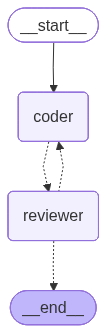

In [67]:
# plot the graph
from IPython.display import display, Image  
display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the Graph

### Example 1

In [68]:
from langchain_core.messages import HumanMessage

my_msg = """Write a function that takes a messy nested JSON object of user data and flattens it into a single-level CSV structure, 
specifically handling conflicting keys by prefixing them with their parent key name.
"""

init_state = {"messages": [HumanMessage(content=my_msg)]}
config = {"configurable": {"thread_id" : "1"}} # needed for memory

for chunk in graph.stream(init_state, config):
    for node_name, values in chunk.items():
        if 'messages' in values:
            print("*"*25)
            print(node_name)
            print("*"*25)
            values['messages'][-1].pretty_print()


*************************
coder
*************************
================================ Human Message =================================

Let me review the code and see if it handles the requirements properly.


```python
import json
from collections import defaultdict
import csv

def flatten_json_with_conflict_resolution(data, parent_key='', sep='_'):
    """
    Flatten a nested JSON object into a single-level dictionary,
    handling conflicting keys by prefixing with parent key names.
    
    Args:
        data (dict): The nested JSON object to flatten
        parent_key (str): The parent key for recursive calls
        sep (str): Separator to use between keys
        
    Returns:
        dict: Flattened dictionary with conflict resolution
    """
    items = {}
    if isinstance(data, dict):
        for k, v in data.items():
            # Create new key name
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            
            if isinstance(v, dict):
    

### Example 2

In [70]:
my_msg = """Write a Python script for a text-based elevator simulator. 
It should handle multiple floor requests, prioritize the direction of travel, and prevent doors from opening while moving.
"""

init_state = {"messages": [HumanMessage(content=my_msg)]}
config = {"configurable": {"thread_id" : "2"}} # needed for memory

for chunk in graph.stream(init_state, config):
    for node_name, values in chunk.items():
        if 'messages' in values:
            print("*"*25)
            print(node_name)
            print("*"*25)
            values['messages'][-1].pretty_print()

*************************
coder
*************************
================================ Human Message =================================

The code I've written provides a complete text-based elevator simulator with the following features:

1. **Multiple Floor Requests**: The system can handle multiple floor requests simultaneously through a set data structure
2. **Directional Prioritization**: It intelligently prioritizes movement based on current direction and request locations
3. **Door Control**: Doors cannot open while the elevator is moving, enforced by state management
4. **Text-Based Interface**: User-friendly command-line interface for requesting floors

Key components include:
- `Elevator` class managing state, floor movement, and requests
- `ElevatorState` and `Direction` enums for proper state tracking
- Priority-based destination selection that considers current direction
- Door opening/closing logic that respects movement constraints
- A main simulator loop for interacti

I probably should've printed the final code in someway: I forgot so I'm copying and pasting it from LangSmith. 

This is the final version of the code that the coder wrote:

```python

import time
import threading
from enum import Enum
from queue import PriorityQueue
from typing import Set

class ElevatorState(Enum):
    STANDING = "standing"
    MOVING_UP = "moving_up"
    MOVING_DOWN = "moving_down"

class Direction(Enum):
    UP = 1
    DOWN = -1
    NONE = 0

class Elevator:
    def __init__(self, total_floors: int = 10):
        self.current_floor = 1
        self.state = ElevatorState.STANDING
        self.direction = Direction.NONE
        self.total_floors = total_floors
        self.destination_floors: Set[int] = set()
        self.door_open = False
        self._lock = threading.RLock()
        self.running = True
        
    def add_request(self, floor: int) -> bool:
        """Add a floor request"""
        if not 1 <= floor <= self.total_floors:
            print(f"Error: Invalid floor {floor}")
            return False
            
        with self._lock:
            self.destination_floors.add(floor)
            print(f"Request added for floor {floor}")
            return True
    
    def move_one_floor(self):
        """Move elevator one floor"""
        if self.direction == Direction.UP:
            self.current_floor += 1
        elif self.direction == Direction.DOWN:
            self.current_floor -= 1
            
        print(f"Moving to floor {self.current_floor}")
    
    def open_doors(self) -> bool:
        """Open elevator doors - only when stopped"""
        with self._lock:
            if self.door_open:
                return True
                
            if self.state != ElevatorState.STANDING:
                print("Cannot open doors while moving!")
                return False
                
            self.door_open = True
            print(f"Doors opening at floor {self.current_floor}")
            
        time.sleep(0.5)  # Door opening simulation
        return True
    
    def close_doors(self) -> bool:
        """Close elevator doors"""
        with self._lock:
            if not self.door_open:
                return True
                
            self.door_open = False
            print("Doors closing")
            
        time.sleep(0.5)  # Door closing simulation
        return True
    
    def get_next_destination(self) -> int:
        """Determine next destination prioritizing current direction"""
        with self._lock:
            if not self.destination_floors:
                return None
                
            # Find floors that match current direction preference
            floors = list(self.destination_floors)
            
            if self.direction == Direction.UP:
                candidates = [f for f in floors if f > self.current_floor]
                if candidates:
                    return min(candidates)
            elif self.direction == Direction.DOWN:
                candidates = [f for f in floors if f < self.current_floor]
                if candidates:
                    return max(candidates)
                    
            # If no matching direction, choose closest
            return min(floors, key=lambda x: abs(x - self.current_floor))
    
    def move_to_destination(self, target_floor: int):
        """Move elevator to target floor"""
        if target_floor == self.current_floor:
            return
            
        # Set movement direction
        with self._lock:
            if target_floor > self.current_floor:
                self.direction = Direction.UP
                self.state = ElevatorState.MOVING_UP
            elif target_floor < self.current_floor:
                self.direction = Direction.DOWN
                self.state = ElevatorState.MOVING_DOWN
            else:
                self.direction = Direction.NONE
                self.state = ElevatorState.STANDING
                
        # Move to target floor one step at a time
        while self.current_floor != target_floor:
            with self._lock:
                self.move_one_floor()
                
            time.sleep(1)  # Movement delay
            
        # Arrived at destination
        with self._lock:
            self.state = ElevatorState.STANDING
            self.direction = Direction.NONE
            
        # Service the floor
        if target_floor in self.destination_floors:
            with self._lock:
                self.destination_floors.remove(target_floor)
                
            # Service floor - open, then close doors
            self.open_doors()
            self.close_doors()
    
    def stop_elevator(self):
        """Stop elevator operations"""
        self.running = False
    
    def get_status(self) -> dict:
        """Get current elevator status"""
        with self._lock:
            return {
                "current_floor": self.current_floor,
                "state": self.state.value,
                "direction": self.direction.name,
                "doors_open": self.door_open,
                "pending_floors": sorted(list(self.destination_floors))
            }

def elevator_thread(elevator: Elevator):
    """Background thread for elevator movement"""
    while elevator.running:
        # Continuously check for work
        with elevator._lock:
            has_destinations = len(elevator.destination_floors) > 0
            is_standing = elevator.state == ElevatorState.STANDING
            
        if has_destinations and is_standing:
            next_dest = elevator.get_next_destination()
            if next_dest:
                elevator.move_to_destination(next_dest)
                
        time.sleep(0.1)

def main():
    print("=== Text-Based Elevator Simulator ===")
    print("Commands:")
    print("- Enter floor number (1-10) to request elevator to that floor")
    print("- 'status' to show elevator status")
    print("- 'quit' to exit")
    print("- 'help' for help")
    
    # Initialize elevator
    elevator = Elevator(total_floors=10)
    
    # Start elevator processing thread
    thread = threading.Thread(target=elevator_thread, args=(elevator,), daemon=True)
    thread.start()
    
    while True:
        try:
            cmd = input("\nEnter floor (1-10), 'status', 'help', or 'quit': ").strip().lower()
            
            if cmd == 'quit':
                print("Shutting down...")
                elevator.stop_elevator()
                break
            elif cmd == 'status':
                status = elevator.get_status()
                print("\n--- Elevator Status ---")
                for k, v in status.items():
                    print(f"{k}: {v}")
                print("---------------------\n")
            elif cmd == 'help':
                print("Floor requests: Enter number 1-10")
                print("'status': Show elevator information")
                print("'quit': Exit simulator")
            elif cmd.isdigit():
                floor = int(cmd)
                elevator.add_request(floor)
            else:
                print("Unknown command")
                
        except (KeyboardInterrupt, EOFError):
            print("\nShutting down...")
            elevator.stop_elevator()
            break

if __name__ == "__main__":
    main()

```

## Final Notes

- Notice that I could've used the structured output even for the coder response, maybe giving it a structured output with fields 'code' and 'message to reviewer' or something like that. This is a completely arbitrary choice. 

    But notice that for a 'non-thinking' model, providing the possibility to use a tool to write code allows the model to call the tool multiple times, if it thinks it needs to (and that's exactly what Qwen did)

    Instead, giving it a structured output would result in just a 'one-shot' answer for code. So you need to think about this stuff while choosing the details of the architecture.

    For example, Claude Haiku 4.5 'reasons', so even with a structured output like above it can think the output through.